In [1]:
from dask.distributed import Client, LocalCluster
import dask.bag as db
import dask.dataframe as df

dask_client = Client(LocalCluster(
    n_workers=10,
    threads_per_worker=1))
dask_client

2022-07-25 09:59:05,955 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-oc_tve2z', purging
2022-07-25 09:59:05,955 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-y2iz22rx', purging
2022-07-25 09:59:05,955 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-7jwzsnux', purging
2022-07-25 09:59:05,956 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-yhn4mlxt', purging
2022-07-25 09:59:05,956 - distributed.diskutils - INFO - Found stale lock file and directory '/home/eeisenst/workspace/compassionai/manas/notebooks/dask-worker-space/worker-dxf6dy2u', purging
2022-07-25 09:59:05,956 - distributed.di

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 31.17 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34557,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:44641,Total threads: 1
Dashboard: http://127.0.0.1:38701/status,Memory: 3.12 GiB
Nanny: tcp://127.0.0.1:34061,


# Dataset creation

## Load the dataset

In [2]:
import os
soas_dataset_path = os.path.join(os.environ['CAI_DATA_BASE_PATH'], "raw_datasets/SOAS-part-of-speech/Texts")
simplifiers_path = os.path.join(os.environ['CAI_DATA_BASE_PATH'], "raw_datasets/Esukhia-SOAS-pos-simplification")

In [3]:
tagged_words = df \
    .read_csv(os.path.join(soas_dataset_path, "*-horizontal.txt"), header=None, names=["folio"]) \
    .folio \
    .str.split(' ') \
    .explode()

In [4]:
tagged_words.count().compute()

319955

In [5]:
tagged_words.head(10)

0               བདེ་བ|n.v.invar
0                  ར་|case.term
0             གཤེགས་པ|n.v.invar
0                  འི་|case.gen
0                བསྟན་བ|n.v.fut
0                  འི་|case.gen
0         གསལ་བྱེད་ཆོས་|n.count
0                 ཀྱི་|case.gen
0    འབྱུང་གནས་གསུང་རབ་|n.count
0                 རིན་པོ་ཆེ|adj
Name: folio, dtype: object

In [6]:
pos_tags_df = df.from_array(tagged_words.str.split('|').values, columns=['tagged_word'])
pos_tags_df = pos_tags_df[pos_tags_df.tagged_word.map(len) == 2]
pos_tags_df.count().compute(), pos_tags_df.head(10)

(tagged_word    318230
 dtype: int64,
                      tagged_word
 0             [བདེ་བ, n.v.invar]
 1                [ར་, case.term]
 2           [གཤེགས་པ, n.v.invar]
 3                [འི་, case.gen]
 4              [བསྟན་བ, n.v.fut]
 5                [འི་, case.gen]
 6       [གསལ་བྱེད་ཆོས་, n.count]
 7               [ཀྱི་, case.gen]
 8  [འབྱུང་གནས་གསུང་རབ་, n.count]
 9               [རིན་པོ་ཆེ, adj])

In [7]:
pos_tags_df['word'] = pos_tags_df.tagged_word.map(lambda x: x[0])
pos_tags_df['tag'] = pos_tags_df.tagged_word.map(lambda x: x[1])
del pos_tags_df['tagged_word']
pos_tags_df.head(10)

,word,tag
0,བདེ་བ,n.v.invar
1,ར་,case.term
2,གཤེགས་པ,n.v.invar
3,འི་,case.gen
4,བསྟན་བ,n.v.fut
5,འི་,case.gen
6,གསལ་བྱེད་ཆོས་,n.count
7,ཀྱི་,case.gen
8,འབྱུང་གནས་གསུང་རབ་,n.count
9,རིན་པོ་ཆེ,adj


## Transform the tags if needed

In [8]:
with open(os.path.join(simplifiers_path, "regex-SOAS-to-UD-BOD.txt"), 'r') as f:
    tag_mapping = f.read()
tag_mapping = eval(tag_mapping.replace('\n', '').replace(' ', ''))
tag_mapping = {left_tag: right_elem for left_elem, right_elem in tag_mapping for left_tag in left_elem.strip('(').strip(')').split('|')}
# tag_mapping

In [9]:
with open(os.path.join(simplifiers_path, "regex-UD-BOD-to-UD-ENG.txt"), 'r') as f:
    tag_remapping = f.read()
tag_remapping = eval(tag_remapping.replace('\n', '').replace(' ', ''))
tag_remapping = {left_tag: right_elem for left_elem, right_elem in tag_remapping for left_tag in left_elem.strip('(').strip(')').split('|')}
# tag_remapping

In [10]:
pos_tags_df["tag"] = pos_tags_df.tag.map(lambda tag: tag_mapping.get(tag, "unk"))
pos_tags_df["tag"] = pos_tags_df.tag.map(lambda tag: tag_remapping.get(tag, "unk"))

In [11]:
len(pos_tags_df[pos_tags_df.tag == "unk"].compute()), \
    len(pos_tags_df.compute()), len(pos_tags_df[pos_tags_df.tag == "unk"].compute()) / len(pos_tags_df.compute())

(6278, 318230, 0.019727869779719073)

In [12]:
pos_tags_df.head()

,word,tag
0,བདེ་བ,NOUN
1,ར་,PART
2,གཤེགས་པ,NOUN
3,འི་,ADP
4,བསྟན་བ,NOUN


In [13]:
pos_tags_df[pos_tags_df.tag == 'PUNCT'].word.unique().compute()

0    །
1    ༑
Name: word, dtype: object

In [14]:
pos_tags_df.npartitions

4

# Concatenate intra-tsheg tokens

In [15]:
import pandas as pd

from tqdm.notebook import tqdm

In [16]:
concat_df = pos_tags_df.compute()

In [17]:
words, tags = [], []
cur_word, cur_tags = "", []
for _, row in tqdm(concat_df.iterrows(), total=len(concat_df)):
    if row.tag == 'PUNCT':
        if len(cur_word) > 0 and len(cur_tags) > 0:
            words.append(cur_word)
            tags.append('+'.join(cur_tags))
        words.append(row.word)
        tags.append(row.tag)
        cur_word, cur_tags = "", []
        continue
    cur_word += row.word
    cur_tags.append(row.tag)
    if row.word[-1] == '་':
        if len(cur_word) == 0 and len(cur_tags) == 0:
            continue
        words.append(cur_word)
        tags.append('+'.join(cur_tags))
        cur_word, cur_tags = "", []

  0%|          | 0/318230 [00:00<?, ?it/s]

In [18]:
concat_tags_df = df.from_pandas(
    pd.DataFrame({
        "section": words,
        "tags": tags}),
    npartitions=10)

In [19]:
concat_tags_df.head(10)

,section,tags
0,བདེ་བར་,NOUN+PART
1,གཤེགས་པའི་,NOUN+ADP
2,བསྟན་བའི་,NOUN+ADP
3,གསལ་བྱེད་ཆོས་,NOUN
4,ཀྱི་,ADP
5,འབྱུང་གནས་གསུང་རབ་,NOUN
6,རིན་པོ་ཆེའི་,ADJ+ADP
7,མཛོད་,NOUN
8,ཅེས་,unk
9,བྱ་བ,NOUN


<AxesSubplot:xlabel='tags'>

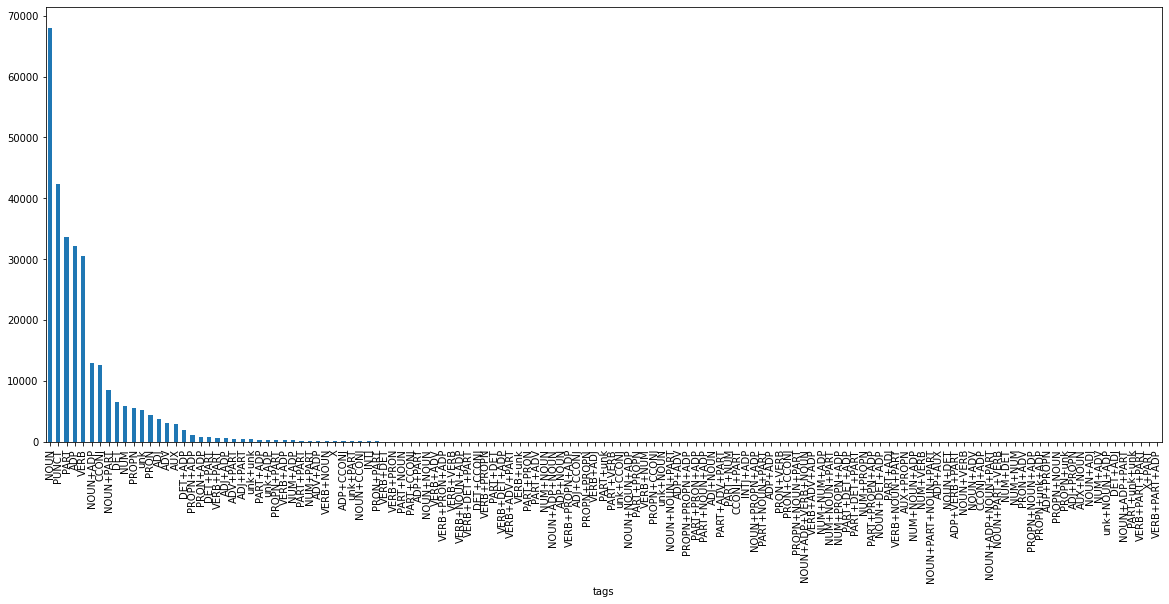

In [20]:
tag_counts = concat_tags_df.groupby("tags").count().compute().section.sort_values(ascending=False)
tag_counts.plot(kind='bar', figsize=(20, 8))

In [21]:
tag_counts[tag_counts > 100], (tag_counts[tag_counts > 100]).sum() / tag_counts.sum(), (tag_counts > 100).sum()

(tags
 NOUN          68081
 PUNCT         42354
 PART          33718
 ADP           32118
 VERB          30536
 NOUN+ADP      12943
 CCONJ         12535
 NOUN+PART      8501
 DET            6473
 NUM            5803
 PROPN          5497
 unk            5179
 PRON           4379
 ADJ            3794
 ADV            3071
 AUX            2840
 DET+ADP        1862
 PROPN+ADP      1165
 PRON+ADP        764
 DET+PART        700
 VERB+PART       659
 ADJ+ADP         542
 ADV+PART        440
 ADJ+PART        403
 unk+unk         369
 PART+ADP        330
 unk+ADP         271
 PROPN+PART      247
 VERB+ADP        221
 NUM+ADP         219
 PART+PART       191
 NUM+PART        118
 ADV+ADP         113
 Name: section, dtype: int64,
 0.9969198213844446,
 33)

## Replace rare tags with unk

In [22]:
to_replace = set(tag_counts[tag_counts <= 100].index.to_list())
', '.join(to_replace)

'PROPN+PROPN, PART+NOUN+ADP, PART+unk, NOUN+ADV, PROPN+unk, PART+DET+PART, PRON+CCONJ, ADP+PROPN, VERB+NOUN+ADP, PRON+ADV, VERB+VERB, PART+unk+unk, NOUN+VERB, PART+NOUN, unk+CCONJ, NUM+NUM+ADP, PART+PRON, unk+NOUN, PART+ADV+PART, NUM+NOUN+ADP, INTJ+ADP, NOUN+CCONJ, NOUN+NOUN+PART, VERB+ADV+PART, NOUN+DET, PRON+PART, PROPN+unk+ADP, NOUN+ADP+PART, NOUN+ADP+VERB+NOUN, PART+CCONJ, X, PART+DET, ADP+ADP, ADP+CCONJ, VERB+DET+PART, PROPN+NOUN+PART, INTJ, X+PART, ADJ+PROPN, NUM+NOUN, AUX+NOUN, NUM+ADV, NOUN+DET+ADP, PART+NUM, PART+PROPN+ADP, VERB+unk, NUM+PROPN+ADP, NOUN+ADP+NOUN, PART+PROPN, PART+NOUN+PART, NOUN+NOUN, VERB+PRON+ADP, NUM+NOUN+PART, ADJ+CCONJ, ADP+AUX, VERB+PRON, AUX+PROPN, PROPN+NOUN, PART+ADV, ADP+NOUN, PROPN+CCONJ, NOUN+NOUN+ADP, NOUN+ADJ, ADP+PART, NUM+PROPN, NOUN+ADP+NOUN+PART, NUM+NUM, unk+NOUN+ADP, PRON+VERB, VERB+PART+PART, PROPN+NOUN+ADP, ADJ+NOUN, NOUN+PART+NOUN+PART, NOUN+PROPN+ADP, DET+CCONJ, VERB+DET+ADP, unk+PART, VERB+ADV+ADP, CCONJ+ADP, VERB+PROPN+ADP, PART+VERB,

In [23]:
len(concat_tags_df[concat_tags_df.tags == 'unk'])

5179

In [24]:
concat_tags_df['tags'] = concat_tags_df.tags.map(lambda tag: 'unk' if tag in to_replace else tag)

In [25]:
len(concat_tags_df[concat_tags_df.tags == 'unk'])

6064

In [26]:
concat_tags_df.tags.unique().count().compute()

33

In [27]:
pos_tags_df = concat_tags_df

In [28]:
pos_tags_df.head(15)

,section,tags
0,བདེ་བར་,NOUN+PART
1,གཤེགས་པའི་,NOUN+ADP
2,བསྟན་བའི་,NOUN+ADP
3,གསལ་བྱེད་ཆོས་,NOUN
4,ཀྱི་,ADP
5,འབྱུང་གནས་གསུང་རབ་,NOUN
6,རིན་པོ་ཆེའི་,ADJ+ADP
7,མཛོད་,NOUN
8,ཅེས་,unk
9,བྱ་བ,NOUN


# Tokenization that first concatenates consecutive words

## Concatenate

In [29]:
import pandas as pd

from tqdm.notebook import tqdm

In [30]:
pos_tags_df = pos_tags_df.compute()

In [31]:
sections, tags = [], []
cur_section, cur_tags = "", []
for _, row in tqdm(pos_tags_df.iterrows(), total=len(pos_tags_df)):
    cur_section += row.section
    cur_tags.append(row.tags)
    if row.tags == 'PUNCT':
        sections.append(cur_section)
        tags.append('|'.join(cur_tags))
        cur_section, cur_tags = "", []
    else:
        cur_section += '|'

  0%|          | 0/287321 [00:00<?, ?it/s]

In [32]:
len(sections), len(tags)

(42354, 42354)

In [33]:
pos_tags_df.head(10)

,section,tags
0,བདེ་བར་,NOUN+PART
1,གཤེགས་པའི་,NOUN+ADP
2,བསྟན་བའི་,NOUN+ADP
3,གསལ་བྱེད་ཆོས་,NOUN
4,ཀྱི་,ADP
5,འབྱུང་གནས་གསུང་རབ་,NOUN
6,རིན་པོ་ཆེའི་,ADJ+ADP
7,མཛོད་,NOUN
8,ཅེས་,unk
9,བྱ་བ,NOUN


In [34]:
sections[0], tags[0]

('བདེ་བར་|གཤེགས་པའི་|བསྟན་བའི་|གསལ་བྱེད་ཆོས་|ཀྱི་|འབྱུང་གནས་གསུང་རབ་|རིན་པོ་ཆེའི་|མཛོད་|ཅེས་|བྱ་བ|།',
 'NOUN+PART|NOUN+ADP|NOUN+ADP|NOUN|ADP|NOUN|ADJ+ADP|NOUN|unk|NOUN|PUNCT')

In [35]:
concat_tags_df = df.from_pandas(
    pd.DataFrame({
        "section": sections,
        "tags": tags}),
    npartitions=10)

In [36]:
concat_tags_df = concat_tags_df[concat_tags_df.tags != 'PUNCT']

In [37]:
concat_tags_df.head(10)

,section,tags
0,བདེ་བར་|གཤེགས་པའི་|བསྟན་བའི་|གསལ་བྱེད་ཆོས་|ཀྱི...,NOUN+PART|NOUN+ADP|NOUN+ADP|NOUN|ADP|NOUN|ADJ+...
1,བཅོམ་ལྡན་འདས་|ཤཱཀྱ་སེང་གེ་|ལ་|ཕྱག་|འཚལ་|ལོ|།,NOUN|PROPN|ADP|NOUN|VERB|PART|PUNCT
3,གང་|ཞིག་|ཐུགས་བསྐྱེད་དགེ་ཚོགས་བདུད་རྩིའི་|ཟས་ཅ...,PART|PART|NOUN+ADP|NOUN|ADP|VERB|NOUN+ADP|NOUN...
5,སྐུ་|གསུམ་|མཐར་|ཕྱིན་རིན་ཆེན་རང་བཞིན་དཔག་ཡས་སྨ...,NOUN|NUM|NOUN+PART|NOUN|VERB|VERB|NOUN|NOUN+AD...
7,སྒྲིབ་|གཉིས་|ཆུ་འཛིན་|བྲལ་བའི་|བྱ་ལམ་|ཡངས་པར་|...,NOUN|NUM|NOUN|NOUN+ADP|NOUN|ADJ+PART|VERB|PART...
9,དྲི་མེད་གསུང་ཟེར་ཚ་ཟེར་|བྱེད་པའི་|འོད་ཟེར་བྱེ་...,NOUN|NOUN+ADP|ADJ|NOUN|NOUN|ADP|PUNCT
11,རབ་བྱུང་སྦྱིན་དགྲ་ཡིད་|ཀྱི་|སྲུབས་ཤིང་|གཙུག་ན་...,NOUN|ADP|NOUN|NOUN|NOUN|NOUN|NOUN|NOUN|PART|PUNCT
13,སྲིད་|གསུམ་|འདི་|ན་|སྟོན་པར་|ཁས་འཆེ་|ཆེ་བར་|མང...,NOUN|NUM|DET|ADP|NOUN+PART|NOUN|NOUN+PART|NOUN...
15,ཐུབ་པ་|སེར་སྐྱ་|རྐང་མིག་པ་|དང་|རིག་བྱེད་|གཞུང་...,NOUN|PROPN|PROPN|CCONJ|PROPN|NOUN|NOUN+ADP|NOU...
17,རྒྱས་པ་|རྔ་བོང་|གྲོག་མཁར་བ་|སོགས་|འབྱུང་པོའི་|...,PROPN|PROPN|PROPN|PART|NOUN+ADP|NOUN|NOUN|PART...


## Tokenize

In [38]:
from cai_manas.tokenizer import CAITokenizerSlow
CAITokenizer = CAITokenizerSlow

In [39]:
tibert_tkn = CAITokenizer.from_pretrained(CAITokenizer.get_local_model_dir("olive-large"))
tibert_tkn.tsheg_pretokenization = True

In [40]:
import unicodedata

def tokenize_section(section, tags, tibert_tkn):
    section = section.replace('༌', '་')
    section, tags = section.split('|'), tags.split('|')
    joined_tokens = tibert_tkn.encode(''.join(section), add_special_tokens=False)
    
    tokens, final_tags = [], []
    cur_tokens, cur_word, cur_tag = [], section[0], tags[0]
    for token in joined_tokens:
        cur_tokens.append(token)
        if cur_word == tibert_tkn.decode(cur_tokens):
            tokens.append(cur_tokens)
            final_tags.append(cur_tag)
            section, tags = section[1:], tags[1:]
            if len(section) == 0:
                break
            cur_tokens, cur_word, cur_tag = [], section[0], tags[0]
    if not len(section) == 0:
        return "BAD SECTION"
    assert len(section) == 0

    return tokens

In [41]:
section, tags = concat_tags_df.head(10).loc[0].section, concat_tags_df.head(10).loc[0].tags
section, tags

('བདེ་བར་|གཤེགས་པའི་|བསྟན་བའི་|གསལ་བྱེད་ཆོས་|ཀྱི་|འབྱུང་གནས་གསུང་རབ་|རིན་པོ་ཆེའི་|མཛོད་|ཅེས་|བྱ་བ|།',
 'NOUN+PART|NOUN+ADP|NOUN+ADP|NOUN|ADP|NOUN|ADJ+ADP|NOUN|unk|NOUN|PUNCT')

In [42]:
tokens = tokenize_section(section, tags, tibert_tkn)
tokens

[[558, 246],
 [2394, 88],
 [912, 137],
 [471, 57, 289],
 [117],
 [583, 212, 1828, 644],
 [1613, 52, 3225],
 [1029],
 [6680],
 [362, 9878],
 [9955]]

In [43]:
[tibert_tkn.decode(cur_tokens) for cur_tokens in tokens], section, tibert_tkn.decode([x for _ in tokens for x in _])

(['བདེ་བར་',
  'གཤེགས་པའི་',
  'བསྟན་བའི་',
  'གསལ་བྱེད་ཆོས་',
  'ཀྱི་',
  'འབྱུང་གནས་གསུང་རབ་',
  'རིན་པོ་ཆེའི་',
  'མཛོད་',
  'ཅེས་',
  'བྱ་བ',
  '།'],
 'བདེ་བར་|གཤེགས་པའི་|བསྟན་བའི་|གསལ་བྱེད་ཆོས་|ཀྱི་|འབྱུང་གནས་གསུང་རབ་|རིན་པོ་ཆེའི་|མཛོད་|ཅེས་|བྱ་བ|།',
 'བདེ་བར་གཤེགས་པའི་བསྟན་བའི་གསལ་བྱེད་ཆོས་ཀྱི་འབྱུང་གནས་གསུང་རབ་རིན་པོ་ཆེའི་མཛོད་ཅེས་བྱ་བ།')

## Run tokenization

In [44]:
concat_tags_df['tokens'] = concat_tags_df.apply(lambda row: tokenize_section(row.section, row.tags, tibert_tkn), axis=1)

/home/eeisenst/miniconda3/envs/cai-garland/lib/python3.10/site-packages/dask/dataframe/core.py:5463: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [45]:
local_dfs = concat_tags_df.compute()

In [46]:
local_dfs[local_dfs.tokens == 'BAD SECTION']

,section,tags,tokens
21188,1|།,NUM|PUNCT,BAD SECTION
21196,2|།,NUM|PUNCT,BAD SECTION
21204,3|།,NUM|PUNCT,BAD SECTION
21212,4|།,NUM|PUNCT,BAD SECTION
21219,འགྱུར་བ་|སྙིང་|ལ་|རྒྱལ་|ཀུན་|བྱིན་རླབས་|དུས་|ག...,NOUN|NOUN|ADP|NOUN|PART|NOUN|NOUN|NUM|unk|PUNCT,BAD SECTION
21227,6|།,NUM|PUNCT,BAD SECTION
21235,7|།,NUM|PUNCT,BAD SECTION
21243,8|།,NUM|PUNCT,BAD SECTION
21250,ཐར་པ་|མཆོག་|ལ་|མྱུར་|དུ་|གནས་པར་|ཤོག9|།,NOUN|ADJ|ADP|VERB|ADP|NOUN+PART|unk|PUNCT,BAD SECTION
21258,10|།,NUM|PUNCT,BAD SECTION


## Save

In [47]:
from tqdm.notebook import tqdm

In [48]:
local_dfs = local_dfs[local_dfs.tokens != 'BAD SECTION']

In [49]:
examples = []

In [50]:
for _, example in tqdm(local_dfs.iterrows(), total=len(local_dfs)):
    examples.append((example.tokens, example.tags.split('|')))

  0%|          | 0/31296 [00:00<?, ?it/s]

In [51]:
examples[0]

([[558, 246],
  [2394, 88],
  [912, 137],
  [471, 57, 289],
  [117],
  [583, 212, 1828, 644],
  [1613, 52, 3225],
  [1029],
  [6680],
  [362, 9878],
  [9955]],
 ['NOUN+PART',
  'NOUN+ADP',
  'NOUN+ADP',
  'NOUN',
  'ADP',
  'NOUN',
  'ADJ+ADP',
  'NOUN',
  'unk',
  'NOUN',
  'PUNCT'])

In [52]:
test_frac = 0.1

In [53]:
import random

In [54]:
train_data, test_data = [], []
for ex in examples:
    if random.random() < test_frac:
        test_data.append(ex)
    else:
        train_data.append(ex)
len(train_data), len(test_data)

(28167, 3129)

In [55]:
import pickle

In [58]:
import os
dataset_dir = os.path.join(os.environ['CAI_DATA_BASE_PATH'], "processed_datasets/part-of-speech-intersyllabic-olive/")

with open(os.path.join(dataset_dir, "dataset.pkl"), 'wb') as f:
    pickle.dump(examples, f)
with open(os.path.join(dataset_dir, "train.pkl"), 'wb') as f:
    pickle.dump(train_data, f)
with open(os.path.join(dataset_dir, "test.pkl"), 'wb') as f:
    pickle.dump(test_data, f)

# Naive tokenization without concatenation

## Tokenize

In [12]:
import tibert.models.training as training

In [13]:
tibert_tkn = training.make_tokenizer(tokenizer_name="tibert-bpe-large")
tibert_tkn.stochastic_tokenization = False
tibert_tkn.tsheg_pretokenization = True

In [14]:
pos_tags_df['tokens'] = pos_tags_df.word.map(lambda word: tibert_tkn.encode(word, add_special_tokens=False))
pos_tags_df.head(10)

,word,tag,tokens
0,བདེ་བ,NOUN,"[558, 9878]"
1,ར་,PART,[733]
2,གཤེགས་པ,NOUN,"[3698, 9890]"
3,འི་,ADP,"[28, 14]"
4,བསྟན་བ,NOUN,"[1060, 9878]"
5,འི་,ADP,"[28, 14]"
6,གསལ་བྱེད་ཆོས་,NOUN,"[711, 57, 289]"
7,ཀྱི་,ADP,[2944]
8,འབྱུང་གནས་གསུང་རབ་,NOUN,"[956, 212, 1828, 644]"
9,རིན་པོ་ཆེ,ADJ,"[790, 52, 9893, 9885]"


In [15]:
pos_tags_df = pos_tags_df.compute()

## Save

In [16]:
from tqdm.notebook import tqdm

In [17]:
examples = []

In [18]:
len(pos_tags_df)

318230

In [19]:
for _, example in tqdm(pos_tags_df.iterrows()):
    examples.append((example.tokens, example.tag))

In [20]:
import pickle

In [21]:
with open("/home/eeisenst/workspace/tibert_data/training/part-of-speech/soas_simple.pkl", 'wb') as f:
    pickle.dump(examples, f)

## Check the pickle file

In [22]:
import pickle

In [23]:
with open("/home/eeisenst/workspace/tibert_data/training/part-of-speech/soas_simple.pkl", 'rb') as f:
    examples = pickle.load(f)

In [24]:
examples[2]

([3698, 9890], 'NOUN')

# Test dataset object examples

In [1]:
from tqdm.notebook import tqdm

In [2]:
from tibert.models.pos_dataset import PoSDataset
import tibert.models.training as training

In [3]:
tibert_tkn = training.make_tokenizer(tokenizer_name="tibert-bpe-large")
tibert_tkn.stochastic_tokenization = False
tibert_tkn.tsheg_pretokenization = True

In [4]:
# PoSDataset.dupe_count = 10
PoSDataset.preprocessed_dataset = "/home/eeisenst/workspace/tibert_data/training/part-of-speech/soas_concat.pkl"
PoSDataset.use_mask_for_word_pieces = True

In [5]:
dataset = PoSDataset(tibert_tkn, verbose=True, tqdm=tqdm)

In [6]:
len(dataset)

3473

In [7]:
dataset.label_to_id_map['PUNCT']

26

In [8]:
len(dataset[0].input_ids), len(dataset[0].label_ids), len(dataset[0].attention_mask), len(dataset[0].token_type_ids)

(128, 272, 128, 128)

In [9]:
', '.join(map(str, dataset[0].input_ids))

'2, 558, 246, 2394, 88, 912, 137, 471, 57, 289, 117, 583, 212, 1828, 644, 1613, 52, 3225, 1029, 6680, 362, 9878, 9955, 3397, 213, 1276, 9901, 9927, 2981, 1296, 458, 17, 1007, 2171, 9888, 9877, 9955, 463, 677, 2239, 1132, 1300, 323, 1518, 2696, 1114, 105, 191, 209, 4525, 11, 179, 33, 2583, 634, 6287, 1248, 1359, 9878, 9955, 399, 149, 1674, 1096, 1613, 119, 467, 386, 1795, 1054, 1933, 253, 3307, 363, 550, 213, 1947, 194, 752, 656, 108, 9955, 3271, 252, 316, 194, 656, 137, 362, 253, 1697, 109, 958, 1944, 1696, 2449, 3249, 475, 611, 323, 1162, 312, 9905, 9886, 9955, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3'

In [10]:
', '.join(map(str, dataset[0].label_ids))

'34, 14, 34, 34, 34, 34, 34, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 3, 34, 34, 12, 34, 34, 34, 1, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 30, 34, 34, 12, 34, 34, 34, 26, 34, 34, 34, 34, 12, 34, 34, 34, 23, 34, 34, 34, 34, 3, 34, 34, 12, 34, 34, 34, 27, 34, 34, 34, 18, 34, 34, 34, 26, 34, 34, 34, 34, 18, 34, 34, 34, 18, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 3, 34, 34, 27, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 12, 34, 34, 34, 26, 34, 34, 34, 34, 12, 34, 34, 34, 15, 34, 34, 14, 34, 34, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 27, 34, 34, 34, 27, 34, 34, 34, 12, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 26, 34, 34, 34, 34, 12, 34, 34, 34, 15, 34, 34, 12, 34, 34, 34, 13, 34, 34, 34, 34, 34, 34, 34, 12, 34, 34, 34, 2, 34, 34, 34, 34, 34, 34, 34, 27, 34, 34, 34, 18, 34, 34, 34, 12, 34, 34, 34, 12, 34, 34, 34, 18, 34, 34, 34, 0, 34, 34, 26, 34, 34, 34, 34, -100, -10

In [12]:
', '.join(map(lambda x: dataset.id_to_label_map[x], dataset[0].label_ids))

'[MASK], NOUN+PART, [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], NOUN+ADP, [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], NOUN+ADP, [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], ADP, [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], ADJ+ADP, [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], unk, [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], PUNCT, [MASK], [MASK], [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], PROPN, [MASK], [MASK], [MASK], [MASK], ADP, [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], VERB, [MASK], [MASK], [MASK], PART, [MASK], [MASK], [MASK], PUNCT, [MASK], [MASK], [MASK], [MASK], PART, [MASK], [MASK], [MASK], PART, [MASK], [MASK], [MASK], NOUN+ADP, [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], NOUN, [MASK], [MASK], [MASK], ADP, [MASK], [MASK], VERB, [MASK], [MASK], [MASK], NOUN+ADP, [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], [MASK], NOUN+ADP, [MASK], [MASK], [MASK], 

In [11]:
dataset.id_to_label_map

{0: 'ADJ',
 1: 'ADJ+ADP',
 2: 'ADJ+PART',
 3: 'ADP',
 4: 'ADV',
 5: 'ADV+ADP',
 6: 'ADV+PART',
 7: 'AUX',
 8: 'CCONJ',
 9: 'DET',
 10: 'DET+ADP',
 11: 'DET+PART',
 12: 'NOUN',
 13: 'NOUN+ADP',
 14: 'NOUN+PART',
 15: 'NUM',
 16: 'NUM+ADP',
 17: 'NUM+PART',
 18: 'PART',
 19: 'PART+ADP',
 20: 'PART+PART',
 21: 'PRON',
 22: 'PRON+ADP',
 23: 'PROPN',
 24: 'PROPN+ADP',
 25: 'PROPN+PART',
 26: 'PUNCT',
 27: 'VERB',
 28: 'VERB+ADP',
 29: 'VERB+PART',
 30: 'unk',
 31: 'unk+ADP',
 32: 'unk+unk',
 -100: '<pad>',
 34: '[MASK]'}

## Train/test split

In [48]:
train_ds, test_ds = dataset.train_test_split()

In [49]:
len(train_ds) / len(dataset), len(test_ds) / len(dataset) 

(0.899251026818072, 0.100748973181928)

# Evaluation of a training run

In [1]:
import pickle

import torch
from tibert.models.training import make_tokenizer
from tibert.models.pos_dataset import PoSDataset

from transformers import (
    AutoConfig,
    AlbertForTokenClassification,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed)

In [2]:
tibert_tkn = make_tokenizer(tokenizer_name='tibert-bpe-large')
tibert_tkn.stochastic_tokenization = False
tibert_tkn.tsheg_pretokenization = True

In [3]:
with open("../../tibert_data/training/models/pos-tagger-concat/train_dataset.pkl", 'rb') as f:
    train_data = pickle.load(f)
with open("../../tibert_data/training/models/pos-tagger-concat/test_dataset.pkl", 'rb') as f:
    test_data = pickle.load(f)

In [4]:
# with open("../../tibert_data/training/models/pos-tagger-no-marpa/train_dataset.pkl", 'rb') as f:
#     train_data = pickle.load(f)
# # with open("../../tibert_data/training/models/pos-tagger-no-marpa/test_dataset.pkl", 'rb') as f:
# #     test_data = pickle.load(f)

# PoSDataset.use_mask_for_word_pieces = True
# test_data = PoSDataset(
#     tibert_tkn,
#     preprocessed_dataset="../../tibert_data/training/part-of-speech/soas_test.pkl",
#     label_to_id_map=train_data.label_to_id_map)

In [5]:
len(train_data), len(test_data)

(3117, 354)

In [6]:
# tibert_mdl = AlbertForTokenClassification.from_pretrained(
#     "../../tibert_data/training/models/pos-tagger/pytorch_model.bin",
#     config=AutoConfig.from_pretrained(
#         'albert-base-v2',
#         vocab_size=10000,
#         num_labels=len(test_data.label_to_id_map),
#         id2label={id_: label for label, id_ in test_data.label_to_id_map.items()},
#         label2id=test_data.label_to_id_map))

tibert_mdl = AlbertForTokenClassification.from_pretrained(
    "../../tibert_data/training/models/pos-tagger-concat/checkpoint-best-f1/pytorch_model.bin",
    config=AutoConfig.from_pretrained(
        'albert-base-v2',
        vocab_size=10000,
        num_labels=len(train_data.label_to_id_map),
        id2label=train_data.id_to_label_map,
        label2id=train_data.label_to_id_map))

tibert_mdl.resize_token_embeddings(len(tibert_tkn))
tibert_mdl.to('cpu')
_ = tibert_mdl.eval()

In [7]:
example = test_data[0]

In [8]:
mdl_res = tibert_mdl(**{
    'input_ids': torch.LongTensor([example.input_ids]),
    'attention_mask': torch.LongTensor([example.attention_mask]),
    'token_type_ids': torch.LongTensor([example.token_type_ids])})[0]

In [9]:
mdl_res.shape

torch.Size([1, 128, 35])

In [10]:
import numpy as np

In [11]:
preds = np.argmax(mdl_res.detach().numpy(), axis=2)[0].tolist()

In [12]:
# [(x, y) for x, y in zip(preds, example.label_ids) if not y == -100]

In [13]:
# [(x, y) for x, y in zip(preds, example.label_ids) if not y == -100 and not x == y]

In [14]:
id_to_label_map = {id_: label for label, id_ in train_data.label_to_id_map.items()}

In [16]:
sorted(id_to_label_map.values())

['<pad>',
 'ADJ',
 'ADJ+ADP',
 'ADJ+PART',
 'ADP',
 'ADV',
 'ADV+ADP',
 'ADV+PART',
 'AUX',
 'CCONJ',
 'DET',
 'DET+ADP',
 'DET+PART',
 'NOUN',
 'NOUN+ADP',
 'NOUN+PART',
 'NUM',
 'NUM+ADP',
 'NUM+PART',
 'PART',
 'PART+ADP',
 'PART+PART',
 'PRON',
 'PRON+ADP',
 'PROPN',
 'PROPN+ADP',
 'PROPN+PART',
 'PUNCT',
 'VERB',
 'VERB+ADP',
 'VERB+PART',
 '[MASK]',
 'unk',
 'unk+ADP',
 'unk+unk']

In [96]:
# [(id_to_label_map[x], id_to_label_map[y]) for x, y in zip(preds, example.label_ids) if not y == -100 and not x == y]

## Precision and recall by part-of-speech tag

In [17]:
from tqdm.notebook import tqdm

In [18]:
import pandas as pd
import numpy as np

In [19]:
from sklearn.metrics import precision_recall_fscore_support

In [20]:
train_tokens = set([token for example in train_data for token in example.input_ids])
test_tokens = set([token for example in test_data for token in example.input_ids])
test_only_tokens = test_tokens.difference(train_tokens)
len(train_tokens), len(test_tokens), len(test_only_tokens)

(4042, 2533, 67)

In [21]:
input_ids = torch.LongTensor([example.input_ids for example in test_data])
attention_mask = torch.LongTensor([example.attention_mask for example in test_data])
token_type_ids = torch.LongTensor([example.token_type_ids for example in test_data])
label_ids = np.array([example.label_ids for example in test_data])
input_ids.shape

torch.Size([354, 128])

In [22]:
ffill_masks = True
test_only_examples = True

def ffill_masks_np(arr):
    arr_df = pd.DataFrame(arr.transpose())
    for c in arr_df.columns:
        arr_df[arr_df[c] == 4] = np.nan
    arr_df = arr_df.fillna(method='ffill').fillna(-100)
    return arr_df.values.transpose()

def word_accuracy(preds, labels):
    word_cnt, correct_words, = 0, 0
    word_pred, word_label = None, None
    for idx, (pred, label) in enumerate(zip(preds, labels)):
        if not label == 4:
            if word_pred is not None:
                word_cnt += 1
                correct_words += 1 if all([p == l for p, l in zip(word_pred, word_label)]) else 0
            word_pred, word_label = [], []
        word_pred.append(pred)
        word_label.append(label)
    return correct_words, word_cnt, correct_words / word_cnt

preds, labels, batch_size = [], [], 8
for idx in tqdm(range(batch_size, input_ids.shape[0], batch_size)):
    cur_res = tibert_mdl(**{
        'input_ids': input_ids[idx:idx + batch_size],
        'attention_mask': attention_mask[idx:idx + batch_size],
        'token_type_ids': token_type_ids[idx:idx + batch_size]})[0]
    cur_preds = np.argmax(cur_res.detach().numpy(), axis=2)
    cur_labels = label_ids[idx:idx + batch_size]
    if ffill_masks:
        cur_labels = ffill_masks_np(cur_labels)
        cur_preds = ffill_masks_np(cur_preds)
    non_padding = np.where(~(cur_labels == -100))
    if test_only_examples:
        cur_inputs = input_ids[idx:idx + batch_size][non_padding].tolist()
        cur_preds, cur_labels = cur_preds[non_padding].tolist(), cur_labels[non_padding].tolist()
        for idx, (pred, label) in enumerate(zip(cur_preds, cur_labels)):
            if cur_inputs[idx] in test_only_tokens:
                preds.append(pred)
                labels.append(label)
    else:
        preds.extend(cur_preds[non_padding].tolist())
        labels.extend(cur_labels[non_padding].tolist())
preds, labels = [train_data.id_to_label_map[p] for p in preds], [train_data.id_to_label_map[l] for l in labels]
print("Number of sequences:", len(preds), len(labels))
print("Word accuracy:", word_accuracy(preds, labels))


Number of sequences: 70 70
Word accuracy: (54, 69, 0.782608695652174)


No-Marpa test set split

In [ ]:
# All test sequences:
precision_recall_fscore_support(preds, labels, average='weighted', zero_division=0)

In [ ]:
# Tokens that appear only in test data:
precision_recall_fscore_support(preds, labels, average='weighted', zero_division=0)

Normal test set split

In [23]:
# All test sequences:
precision_recall_fscore_support(preds, labels, average='weighted', zero_division=0)

(0.7497906855049711, 0.7857142857142857, 0.7651224214382109, None)

In [24]:
# Tokens that appear only in the test data:
precision_recall_fscore_support(preds, labels, average='weighted', zero_division=0)

(0.7497906855049711, 0.7857142857142857, 0.7651224214382109, None)

In [25]:
precision, recall, fscore, support = precision_recall_fscore_support(
    preds,
    labels,
    zero_division=0,
    labels=sorted(list(set(labels).union(set(preds)))))

In [26]:
res_df = pd \
    .DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "fscore": fscore,
            "support": support},
        index=[label for label in sorted(list(set(labels).union(set(preds))))]) \
    .sort_values('support')

<AxesSubplot:>

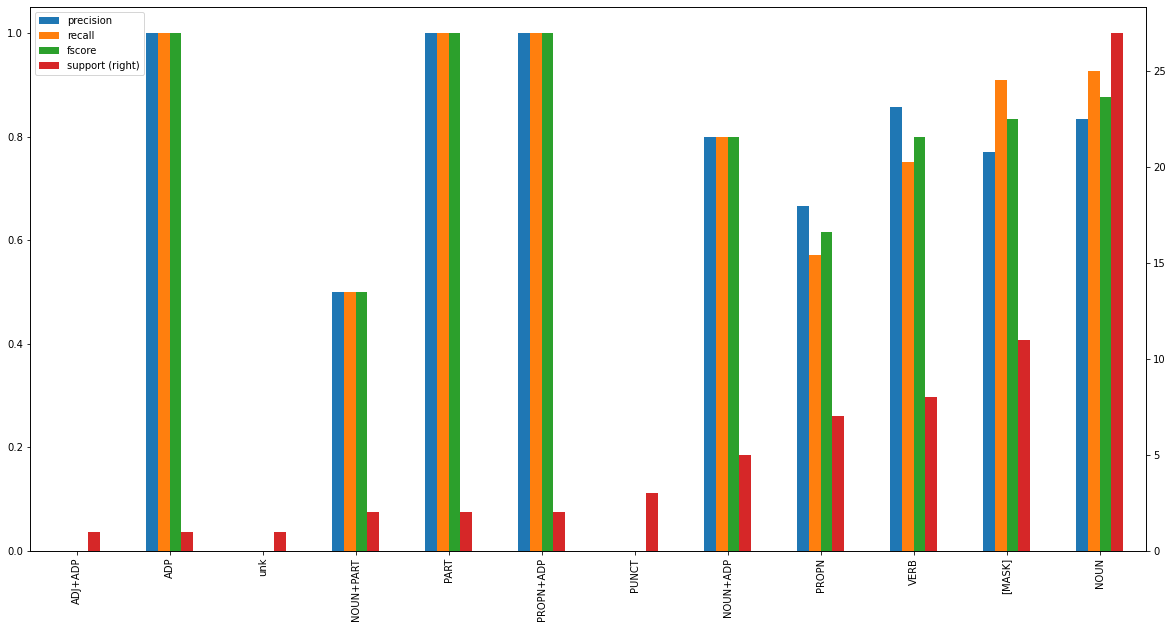

In [27]:
res_df[res_df.support > 0] \
    .plot(kind='bar', secondary_y='support', figsize=(20, 10))

<AxesSubplot:>

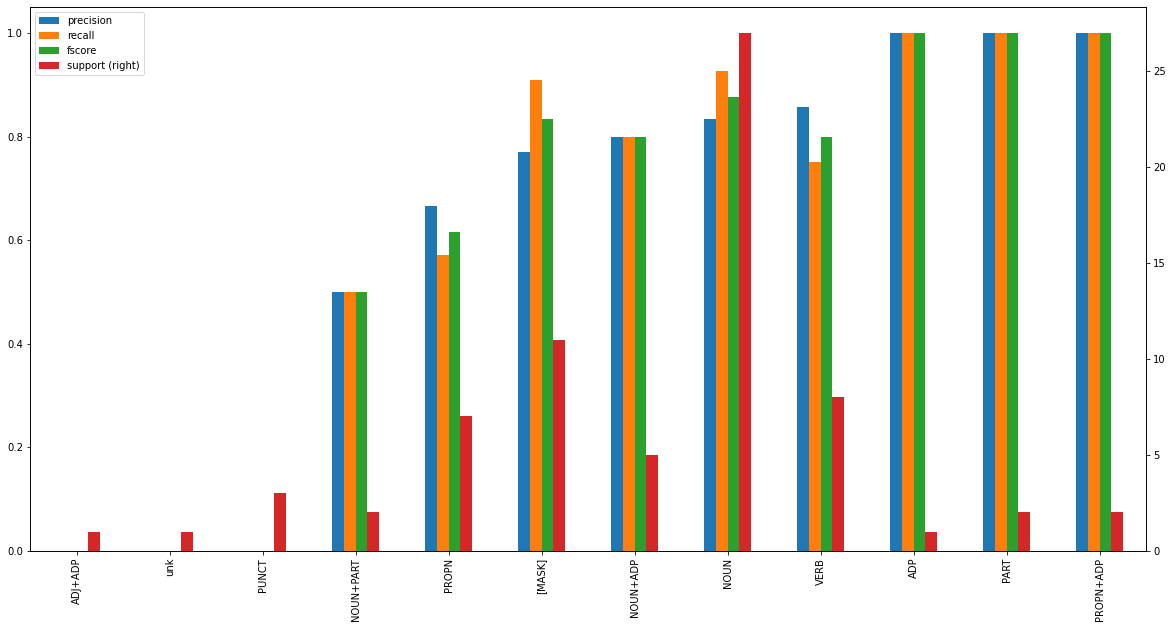

In [28]:
res_df[res_df.support > 0] \
    .sort_values('precision') \
    .plot(kind='bar', secondary_y='support', figsize=(20, 10))

In [29]:
res_df

,precision,recall,fscore,support
ADJ,0.000000,0.000000,0.000000,0
PRON,0.000000,0.000000,0.000000,0
ADJ+ADP,0.000000,0.000000,0.000000,1
ADP,1.000000,1.000000,1.000000,1
unk,0.000000,0.000000,0.000000,1
NOUN+PART,0.500000,0.500000,0.500000,2
PART,1.000000,1.000000,1.000000,2
PROPN+ADP,1.000000,1.000000,1.000000,2
PUNCT,0.000000,0.000000,0.000000,3
NOUN+ADP,0.800000,0.800000,0.800000,5


In [27]:
res_df.loc['n.count']

precision       0.942586
recall          0.917128
fscore          0.929683
support      9219.000000
Name: n.count, dtype: float64

In [28]:
res_df.loc['v.invar']

precision       0.867360
recall          0.864550
fscore          0.865953
support      1543.000000
Name: v.invar, dtype: float64

In [29]:
tags = [
    "n.count",
    "punc",
    "case.gen",
    "case.term",
    "case.agn",
    "v.past",
    "n.v.invar",
    "d.dem",
    "case.all",
    "v.invar"]

In [30]:
res_df[['precision', 'recall', 'fscore']].loc[tags]

,precision,recall,fscore
n.count,0.942586,0.917128,0.929683
punc,1.000000,0.998272,0.999135
case.gen,0.992033,0.989634,0.990832
case.term,0.990136,0.990602,0.990369
case.agn,0.995083,0.991427,0.993252
v.past,0.959169,0.939649,0.949309
n.v.invar,0.946985,0.942612,0.944793
d.dem,0.981195,0.972588,0.976872
case.all,0.993956,0.991293,0.992622
v.invar,0.867360,0.864550,0.865953


## Validate tokens

In [4]:
example = test_data[13]

In [5]:
' '.join(map(str, example.input_ids))

'2 1030 638 474 798 1714 16 4917 368 17 289 1720 246 31 9887 9877 9955 3018 251 9955 1860 251 186 3083 1025 912 109 31 9887 9877 9955 3018 731 198 846 137 1101 9880 9877 9955 1169 16 912 617 9886 9882 9955 567 9909 9882 9879 9955 698 9899 9882 9876 9955 2479 18 149 368 1199 109 362 16 9888 9875 9955 1076 52 9886 9882 9955 2316 16 52 441 2465 84 88 1639 105 368 267 33 312 728 1944 1318 18 672 88 253 251 731 198 563 16 87 9885 9955 854 952 9883 9880 9955 463 677 314 137 912 16 8488 677 9876 9882 9955 0 0 0 0 0 0 0 0 0 0 3'

In [6]:
tibert_tkn.decode(example.input_ids)

'[CLS] འདི་སྐད་བདག་གིས་ཐོས་པ་ཞེས་གྱིས་ལ་ཆོས་བསྡུ་བར་བྱའོ། ཞེས་དང་། འབྲེལ་དང་གོ་རིམས་ཀྱང་བསྟན་པར་བྱའོ། ཞེས་རྗེས་སུ་གནང་བའི་ཕྱིར་རོ། གཉིས་པ་བསྟན་བཅོས་ནི། མཚན་ཉིད། ངེས་ཚིག། དབྱེ་བ་གསུམ་གྱིས་ངེས་པར་བྱ་པ་ལས། དང་པོ་ནི། རྩོམ་པ་པོ་རྣམ་གཡེང་མེད་པའི་ཡིད་ཅན་གྱིས་བཀའི་དོན་བཤད་ཅིང་ཐར་བ་ཐོབ་པའི་ལམ་དང་རྗེས་སུ་མཐུན་པ་སྟེ། རྒྱུད་བླ་མར། གང་ཞིག་རྒྱལ་བའི་བསྟན་པ་འབའ་ཞིག་གི།<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>[SEP]'

In [7]:
' '.join([str((tibert_tkn.decode(token), test_data.id_to_label_map[label])) for token, label in zip(example.input_ids, example.label_ids)])

"('[CLS]', '[MASK]') ('འདི་', 'DET') ('སྐད་', 'NOUN') ('བདག་', 'PRON') ('གིས་', 'ADP') ('ཐོས་', 'NOUN') ('པ་', '[MASK]') ('ཞེས་', 'unk') ('གྱིས་', 'ADP') ('ལ་', 'ADP') ('ཆོས་', 'NOUN') ('བསྡུ་', 'NOUN+PART') ('བར་', '[MASK]') ('བྱ', 'VERB+PART') ('འ', '[MASK]') ('ོ', '[MASK]') ('།', 'PUNCT') ('ཞེས་', 'unk') ('དང་', 'CCONJ') ('།', 'PUNCT') ('འབྲེལ་', 'VERB') ('དང་', 'PART') ('གོ་', 'NOUN') ('རིམས་', '[MASK]') ('ཀྱང་', 'CCONJ') ('བསྟན་', 'NOUN+PART') ('པར་', '[MASK]') ('བྱ', 'VERB+PART') ('འ', '[MASK]') ('ོ', '[MASK]') ('།', 'PUNCT') ('ཞེས་', 'unk') ('རྗེས་', 'NOUN') ('སུ་', 'PART') ('གནང་', 'NOUN+ADP') ('བའི་', '[MASK]') ('ཕྱིར་', 'NOUN+PART') ('ར', 'PART') ('ོ', '[MASK]') ('།', 'PUNCT') ('གཉིས་', 'ADJ') ('པ་', '[MASK]') ('བསྟན་', 'NOUN') ('བཅོས་', '[MASK]') ('ན', 'CCONJ') ('ི', '[MASK]') ('།', 'PUNCT') ('མཚན་', 'NOUN') ('ཉ', '[MASK]') ('ི', '[MASK]') ('ད', '[MASK]') ('།', 'PUNCT') ('ངེས་', 'NOUN') ('ཚ', '[MASK]') ('ི', '[MASK]') ('ག', '[MASK]') ('།', 'PUNCT') ('དབྱེ་', 'NOUN') ('བ་', '

In [9]:
tibert_tkn('འདི་སྐད་བདག་གིས་ཐོས་པ་ཞེས་གྱིས་ལ་ཆོས་བསྡུ་བར་བྱའོ། ཞེས་དང་། འབྲེལ་དང་གོ་རིམས་ཀྱང་བསྟན་པར་བྱའོ། ཞེས་རྗེས་སུ་གནང་བའི་ཕྱིར་རོ། གཉིས་པ་བསྟན་བཅོས་ནི། མཚན་ཉིད། ངེས་ཚིག། དབྱེ་བ་གསུམ་གྱིས་ངེས་པར་བྱ་པ་ལས། དང་པོ་ནི། རྩོམ་པ་པོ་རྣམ་གཡེང་མེད་པའི་ཡིད་ཅན་གྱིས་བཀའི་དོན་བཤད་ཅིང་ཐར་བ་ཐོབ་པའི་ལམ་དང་རྗེས་སུ་མཐུན་པ་སྟེ། རྒྱུད་བླ་མར། གང་ཞིག་རྒྱལ་བའི་བསྟན་པ་འབའ་ཞིག་གི།')

{'input_ids': [2, 1030, 638, 474, 798, 1714, 16, 4917, 368, 17, 289, 1720, 246, 31, 9887, 9877, 9955, 3018, 251, 9955, 1860, 251, 186, 3083, 1025, 912, 109, 31, 9887, 9877, 9955, 3018, 731, 198, 846, 137, 1101, 9880, 9877, 9955, 1169, 16, 912, 617, 9886, 9882, 9955, 567, 9909, 9882, 9879, 9955, 698, 9899, 9882, 9876, 9955, 2479, 18, 149, 368, 1199, 109, 362, 16, 9888, 9875, 9955, 1076, 52, 9886, 9882, 9955, 2316, 16, 52, 441, 2465, 84, 88, 1639, 105, 368, 267, 33, 312, 728, 1944, 1318, 18, 672, 88, 253, 251, 731, 198, 563, 16, 87, 9885, 9955, 854, 952, 9883, 9880, 9955, 463, 677, 314, 137, 912, 16, 8488, 677, 9876, 9882, 9955, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 